<a href="https://colab.research.google.com/drive/1btmWSPRUtL2b-md_Iaxw7vtdSOasp61Y" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon - Particle Images
## Problem Statement 
*   One of the important aspects of searches for new physics at the Large Hadron Collider (LHC) involves the classification of various High-Energy Particles in collision events
*   The goal of this challenge is to develop a model which classifies electron and photon electromagnetic showers as accurately as possible based on the detector images provided in the dataset below (one pixel = one channel of the detector)
*   The preferred metric for evaluating the model is ROC curve (Receiver Operating Characteristic curve) and the AUC (Area Under the ROC Curve) score.
*   Although we are using Keras Framework in this sample notebook, you are free to choose Machine Learning / Deep Learning Framework of your choice. 



## Download our Model from GitHub 

In [ ]:
!git clone https://github.com/ekoenig4/ParticleImages.git

Cloning into 'ParticleImages'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (465/465), done.
remote: Compressing objects: 100% (318/318), done.
remote: Total 541 (delta 186), reused 412 (delta 137), pack-reused 76
Receiving objects: 100% (541/541), 388.37 MiB | 29.34 MiB/s, done.
Resolving deltas: 100% (218/218), done.


# Import modules

In [ ]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from tensorflow.keras.layers import MaxPool2D, Input, Dense, Dropout, Flatten, Conv2D, AveragePooling2D, concatenate
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
import pickle

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Keras Model Parameters

In [ ]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 500       # Training batch size
train_size  = 100000     # Training size
valid_size  = 44000     # Validation size
test_size   = 5000     # Test size
epochs      = 100       # Number of epochs
doGPU       = True    # Use GPU

## It is recommended to use GPU for training and inference if possible.

In [ ]:
if doGPU:
    import tensorflow.compat.v1 as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

# Load Image Data
### Two classes of particles: electrons and photons
### 32x32 matrices (two channels - hit energy and time) for the two classes of particles electrons and photons impinging on a calorimeter (one calorimetric cell = one pixel).
#### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

In [ ]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'ParticleImages/data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

# Configure Training / Validation / Test Sets

In [ ]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

### We only use the energy channel, and we vectorize the target labels to be able to use a softmax output activation

In [ ]:
X_train = X_train[:,:,:,0]
y_train = to_categorical(y_train)

X_valid = X_valid[:,:,:,0]
y_valid = to_categorical(y_valid)

X_test = X_test[:,:,:,0]
y_test = to_categorical(y_test)

# Define BearNet Model
## Based on GoogLeNet

In [ ]:

kernel_init = 'TruncatedNormal'
bias_init = Constant(value=5e-4)

# references for GoogLeNet inception network
# https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
# https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):

    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu',
                       kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5,
                         pool_proj], axis=3, name=name)

    return output


def bearnet_truncated(input):
    x = Conv2D(32, (3, 3), padding='same', strides=1,
               activation='relu', name='conv_1_3x3')(input)
    x = MaxPool2D((2, 2), padding='same', strides=2, name='max_pool_1_3x3')(x)
    x = Conv2D(32, (2, 2), padding='same', strides=(1, 1),
               activation='relu', name='conv_2a_2x2')(x)
    x = Conv2D(96, (2, 2), padding='same', strides=(1, 1),
               activation='relu', name='conv_2b_2x2')(x)
    x = MaxPool2D((2, 2), padding='same', strides=1,
                  name='max_pool_2_2x2/2')(x)

    x = inception_module(x,
                         filters_1x1=32,
                         filters_3x3_reduce=48,
                         filters_3x3=64,
                         filters_5x5_reduce=16,
                         filters_5x5=16,
                         filters_pool_proj=16,
                         name='inception_3a')
    x = inception_module(x,
                         filters_1x1=64,
                         filters_3x3_reduce=64,
                         filters_3x3=96,
                         filters_5x5_reduce=16,
                         filters_5x5=48,
                         filters_pool_proj=32,
                         name='inception_3b')

    x = MaxPool2D((2, 2), padding='same', strides=(
        2, 2), name='max_pool_3_2x2/2')(x)
    x = inception_module(x,
                         filters_1x1=96,
                         filters_3x3_reduce=48,
                         filters_3x3=104,
                         filters_5x5_reduce=16,
                         filters_5x5=24,
                         filters_pool_proj=32,
                         name='inception_4a')

    x1 = AveragePooling2D((2, 2), strides=2)(x)
    x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
    x1 = Flatten()(x1)
    x1 = Dense(1024, activation='relu')(x1)
    x1 = Dropout(0.4)(x1)
    x1 = Dense(2, activation='softmax', name='output')(x1)
    model = Model(input, [x1], name='inception_v1')
    return model


input = Input(shape=(32, 32, 1))
model = bearnet_truncated(input)

model.summary()


Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv_1_3x3 (Conv2D)            (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pool_1_3x3 (MaxPooling2D)  (None, 16, 16, 32)   0           ['conv_1_3x3[0][0]']             
                                                                                                  
 conv_2a_2x2 (Conv2D)           (None, 16, 16, 32)   4128        ['max_pool_1_3x3[0][0]']         
                                                                                       

## Train the Model

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
earlystop = EarlyStopping(monitor='loss', patience=3)

model.compile(loss='binary_crossentropy', optimizer=Adam(
    learning_rate=lr_init), metrics=['accuracy', AUC()])

to_fit = False

if to_fit:
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_valid, y_valid),
        callbacks=[reduce_lr, earlystop],
        verbose=1, shuffle=True
    )


## Load the Trained Model

In [ ]:
modeldir = 'ParticleImages/bearnet-truncated'
model = load_model(modeldir)
with open(f'{modeldir}/history.pkl','rb') as f_history: history = pickle.load(f_history)

model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv_1_3x3 (Conv2D)            (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pool_1_3x3 (MaxPooling2D)  (None, 16, 16, 32)   0           ['conv_1_3x3[0][0]']             
                                                                                                  
 conv_2a_2x2 (Conv2D)           (None, 16, 16, 32)   4128        ['max_pool_1_3x3[0][0]']         
                                                                                       

## Evaluate the Model  

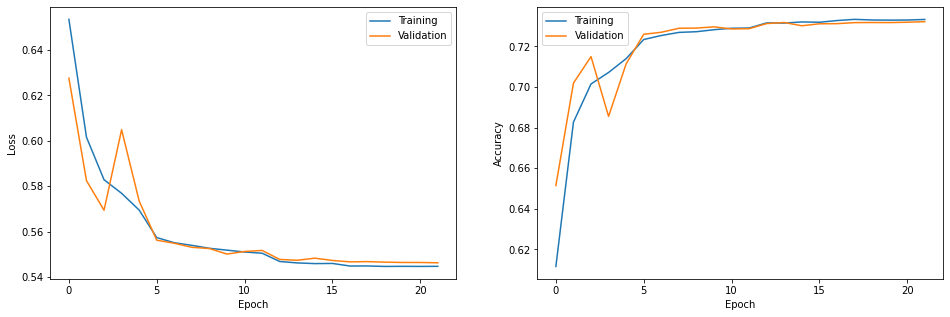

In [ ]:
# Training History
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,2,1)
ax.plot(history['loss'],label='Training')
ax.plot(history['val_loss'],label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(history['accuracy'],label='Training')
ax.plot(history['val_accuracy'],label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

In [ ]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid[:,0], y_pred[:,0])
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test[:,0], y_pred[:,0])
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

2750/2750 [==============================] - 43s 13ms/step - loss: 0.5460 - accuracy: 0.7325 - auc: 0.7981

Validation loss / accuracy: 0.5460 / 0.7325
Validation ROC AUC: 0.7969489584194216
313/313 [==============================] - 4s 13ms/step - loss: 0.5480 - accuracy: 0.7278 - auc: 0.7958

Test loss / accuracy: 0.5480 / 0.7278
Test ROC AUC: 0.79447828


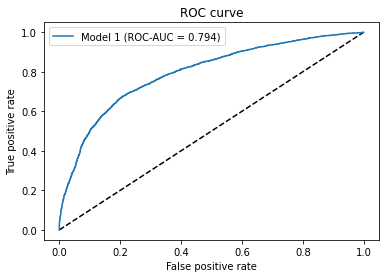

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()